# MCMC: Understanding and usage

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import corner

%matplotlib inline

## Create a simple Metropolis MCMC
- based on:  
https://github.com/AstroHackWeek/AstroHackWeek2016/blob/master/day4-sampling/Worksheet.ipynb

- the talk related to the Worksheet notebook above (starting from 1:50:40):
https://www.youtube.com/watch?v=3Xk2Rv5_Z0A&list=PLKW2Azk23ZtQSHmwOpObPEr58Pe1rpIdB&index=3


### Simple Metropolis

In [4]:
def mh(log_p_func, theta0, niter, sigma=0.1):
    ndim = len(theta0)
    theta = np.array(theta0)
    chain = np.empty((niter, ndim))
    lp = log_p_func(theta0)
    acc = 0
    for i in range(niter):
        q = np.array(theta)
        ind = np.random.randint(ndim)
        q[ind] += sigma * np.random.randn()
        lq = log_p_func(q)

        u = np.log(np.random.rand())
        if u < lq - lp:
            theta = q
            lp = lq
            acc += 1

        chain[i] = theta

    print("Acceptance fraction: {0:.3f}".format(acc / niter))

    return chain

### Convergence

Implement a function to compute the autocorrelation function. This should take in a one-dimensional chain and return a different autocorrelation function for each parameter. You probably shouldn't compute this using a direct sum – it will be too slow! – [try using a fast Fourier transform](https://en.wikipedia.org/wiki/Autocorrelation#Efficient_computation).

In [11]:
def acorfn(x):
    n = len(x)
    f = np.fft.rfft(x - np.mean(x), n=2*n)
    acf = np.fft.irfft(f * np.conjugate(f))[:n].real
    return acf / acf[0]

Computing autocorrelation time:
Read the suggested heuristic method for computing autocorelation times from pages 15-16 of [this note](http://www.stat.unc.edu/faculty/cji/Sokal.pdf) and implement 

In [12]:
def autocorr_time_simple(acf, window):
    return 1 + 2 * np.sum(acf[1:window])

def autocorr_time_iterative(acf, c=10, low=10):
    high = int(len(acf) / c)
    for M in np.arange(low, high).astype(int):
        tau = autocorr_time_simple(acf, M)
        if tau > 1.0 and M > c * tau:
            return tau
    raise RuntimeError("chain too short to estimate tau reliably")

# print(autocorr_time_iterative(acorfn(chain[:, 0])), autocorr_time_iterative(acorfn(chain[:, 1])))

### Sample linear data

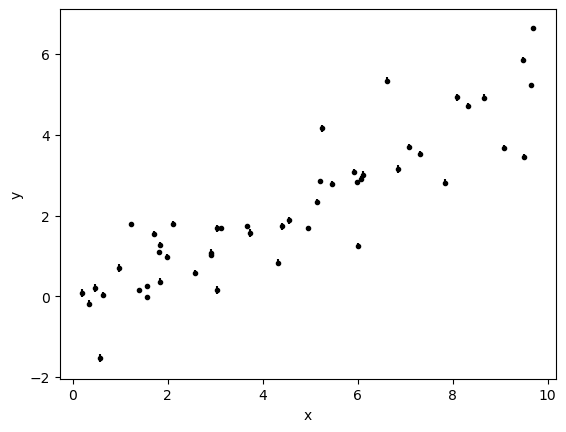

In [59]:
# local copy of https://github.com/AstroHackWeek/AstroHackWeek2016/blob/master/day4-sampling/data.txt
x, y, yerr = np.loadtxt("tmp/mcmc_understanding_sample_data.txt", unpack=True)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y");


### Model

The model that we'll use in this case is a linear model with a "jitter" term. In this model, the likelihood is:

$$
\ln p (y\,|\,m,\,b,\,s) = -\frac{1}{2} \sum_{n=1}^N\left[ \left(\frac{y_n-m\,x_n-b}{\sigma^2 + e^{s}}\right)^2 + \ln(2\,\pi\,(\sigma^2 + e^{s}))\right]
$$

and the prior is:

$$
\ln p(m,\,b,\,s) \propto -\frac{3}{2}\ln(1+b^2)
$$

(see [this blog post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) for more details about this choice of prior).

Implement this model in code:

In [3]:
def log_prior(m, b, s):
    return -1.5 * np.log(1 + b**2)

def log_likelihood(m, b, s):
    mod = m * x + b
    var = np.sqrt(yerr**2 + np.exp(s))
    return -0.5 * np.sum((y-mod)**2/var + np.log(var))

def log_posterior(theta):
    return log_prior(*theta) + log_likelihood(*theta)


### Run MCMC

In [ ]:
line_chain = mh(
    log_posterior,
    np.random.randn(3),  # has random starting point
    200000,  # num. iterations
)

Acceptance fraction: 0.639


#### Trace plot / chain plot

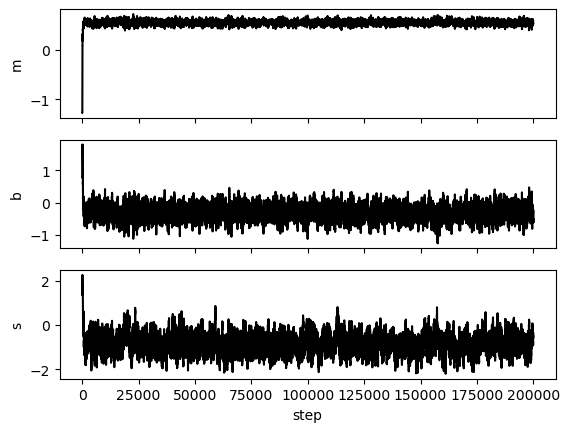

In [6]:
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(line_chain[:, 0], "k")
axes[0].set_ylabel("m")
axes[1].plot(line_chain[:, 1], "k")
axes[1].set_ylabel("b")
axes[2].plot(line_chain[:, 2], "k")
axes[2].set_ylabel("s")
axes[2].set_xlabel("step");

#### Convergence: Autocorrelation

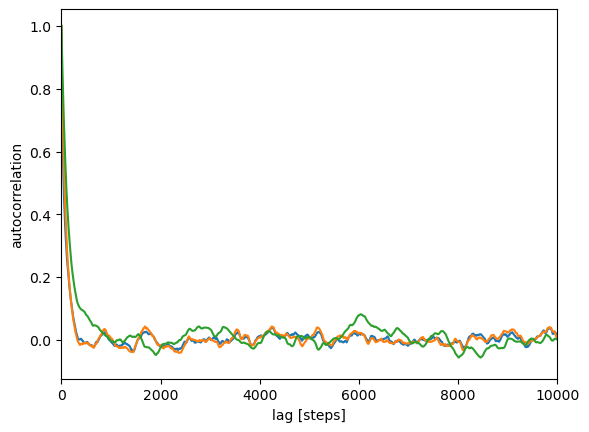

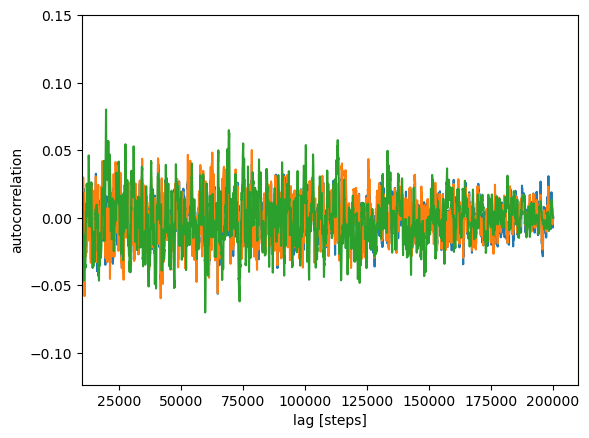

In [28]:
# settle down after about 2000 steps
plt.plot(acorfn(line_chain[:, 0]))
plt.plot(acorfn(line_chain[:, 1]))
plt.plot(acorfn(line_chain[:, 2]))
plt.xlim(0, 10000)

plt.xlabel("lag [steps]")
plt.ylabel("autocorrelation");
plt.show();

plt.plot(acorfn(line_chain[:, 0]))
plt.plot(acorfn(line_chain[:, 1]))
plt.plot(acorfn(line_chain[:, 2]))
plt.xlim(10000, None)
plt.ylim(None, 0.15)

plt.xlabel("lag [steps]")
plt.ylabel("autocorrelation");
plt.show();

Compute the autocorrelation times:

In [29]:
print(autocorr_time_iterative(acorfn(line_chain[:, 0])),
      autocorr_time_iterative(acorfn(line_chain[:, 1])),
      autocorr_time_iterative(acorfn(line_chain[:, 2])))

141.09834952227877 147.5282251299228 361.48771370130595


#### Discard early chains and create Posterior Statistical Summary

In [52]:
def create_posterior_summary(chain_dict):
    stats_dict = {}
    for param_name, chain in chain_dict.items():
        stats_dict[param_name] = dict(
            mean=np.nanmean(chain),
            std=np.nanstd(chain),
            num_iter=len(chain),
        )
    return stats_dict

# by eyeballing trace plots and autocorrelation plots
num_discards = 100000

line_chain_chosen = line_chain[num_discards:]

line_chain_stats = create_posterior_summary(dict(
    m=line_chain_chosen[:, 0],
    b=line_chain_chosen[:, 1],
    s=line_chain_chosen[:, 2],
))

line_chain_stats

{'m': {'mean': 0.5522228665023546,
  'std': 0.03992645064391865,
  'num_iter': 100000},
 'b': {'mean': -0.30507500455957254,
  'std': 0.208872318742798,
  'num_iter': 100000},
 's': {'mean': -0.8426218856910975,
  'std': 0.4239960604891499,
  'num_iter': 100000}}

#### The [corner plot](http://corner.readthedocs.io/)

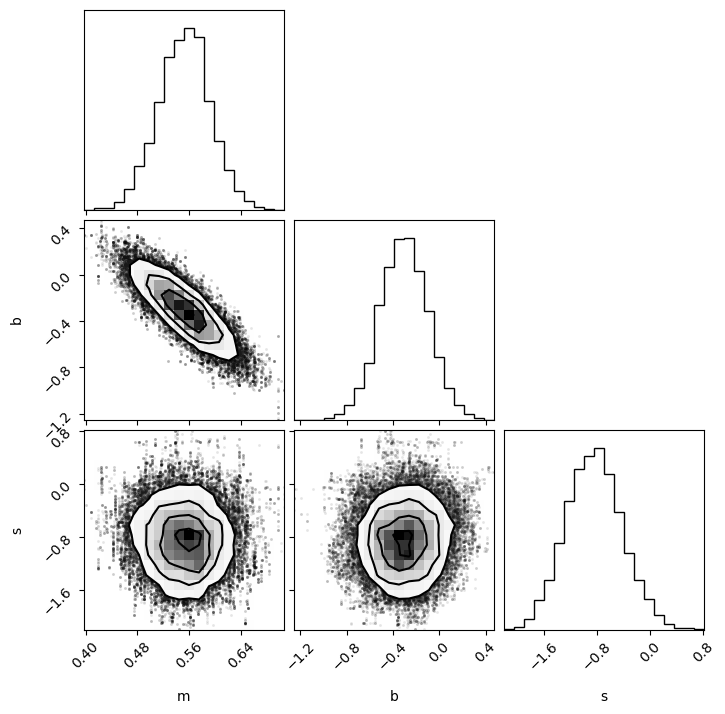

In [53]:
corner.corner(line_chain_chosen, labels=["m", "b", "s"]);

#### Model posterior prediction in the data space

Finally, plot the posterior prediction of the model in the data space. The best way to do this is to overplot the predicted line for several samples from the posterior on the data. Here is what it might look like:

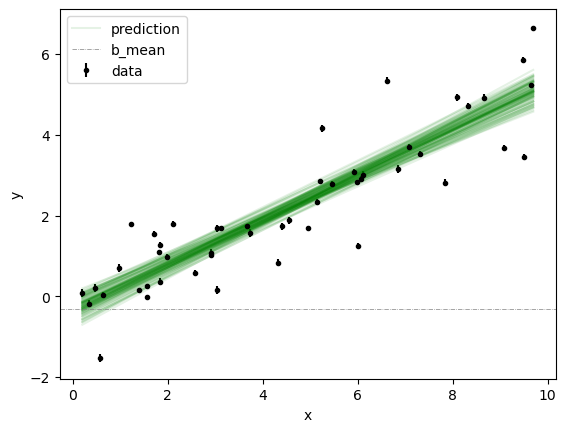

In [58]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="data")

for i, idx in enumerate(np.random.randint(len(line_chain_chosen), size=100)):
    m, b, _ = line_chain_chosen[idx]
    label = "prediction" if i == 0 else None
    plt.plot(x, m*x+b, "g", alpha=0.1, label=label)

plt.xlabel("x")
plt.ylabel("y");

plt.axhline(line_chain_stats["b"]["mean"], c="gray", lw=0.5, linestyle="-.", label="b_mean");
plt.legend();